# Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')
import random
random.seed(530)

from glob import glob
from tqdm.auto import tqdm

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

import tensorflow as tf
from keras import optimizers
from keras.layers import Dense, Flatten, Input, concatenate, Embedding, Dropout, LSTM, TimeDistributed, ConvLSTM2D
from keras.callbacks import EarlyStopping

# Data Load

In [3]:
data_path = "/content/drive/MyDrive/DKU/Ubiosis/total_data.csv"
data_df = pd.read_csv(data_path)

## Data Pre-Processing

In [5]:
def prepare_dataset(data_df, c_mode = "all", r_mode="org", scale_list = [1,1,1,1,1,1,1,1,1]):
    # 결측치 제거
    data_df.dropna(axis=0,inplace=True)

    # 데이터 정보 별 데이터프레임 분할
    radius_df = data_df.iloc[:,:1]
    cis1_df = data_df.iloc[:,1:6001]
    cis2_df = data_df.iloc[:,6001:12001]
    shear_df = data_df.iloc[:,12001:]
    shear_df = shear_df.div(scale_list, axis=1)
    re_cols = ["1","2","5","10","50","100","150","300","1000"]
    re_shear_df = shear_df[re_cols]

    if r_mode == "org":
        if c_mode == "all":
            data = pd.concat([radius_df, cis1_df, cis2_df,re_shear_df],axis=1)
        elif c_mode == "only2":
            data = pd.concat([radius_df, cis2_df,re_shear_df],axis=1)
        else:
            data = pd.DataFrame()

    elif r_mode == "ohe":
        # one-hot encoding
        ohe_cols = []
        for i in range(0,19):
            ohe_cols.append(((310+i)/100))

        ohe_target = np.array(ohe_cols).reshape(-1,1)
        ohe_value = np.array(radius_df["RADIUS"]).reshape(-1,1)

        ohe = OneHotEncoder()
        ohe.fit(ohe_target)

        ohe_labels = ohe.transform(ohe_value)
        ohe_targets = ohe_labels.toarray()

        ohe_df = pd.DataFrame(columns=ohe_cols,data=ohe_targets)

        if c_mode == "all":
            data = pd.concat([ohe_df, cis1_df, cis2_df,re_shear_df],axis=1)
        elif c_mode == "only2":
            data = pd.concat([ohe_df, cis2_df,re_shear_df],axis=1)
        else:
            data = pd.DataFrame()
    else:
        data = pd.DataFrame()

    return data

c_mode = "only2" # all / only2
r_mode = "org" # org / ohe
scale_list = [10,10,10,10,10,10,10,15,20]

data = prepare_dataset(data_df, c_mode, r_mode, scale_list)
data.tail(3)

,RADIUS,CIS_2_1,CIS_2_2,CIS_2_3,CIS_2_4,CIS_2_5,CIS_2_6,CIS_2_7,CIS_2_8,CIS_2_9,...,CIS_2_6000,1,2,5,10,50,100,150,300,1000
79333,3.20,108.0,108.0,108.0,108.0,108.0,108.0,108.0,108.0,109.0,...,523.0,1.525,1.30,1.17,0.85,0.51,0.44,0.41,0.37,0.31
79334,3.16,107.0,107.0,107.0,107.0,107.0,107.0,107.0,108.0,109.0,...,517.0,0.255,0.28,0.35,0.32,0.27,0.27,0.26,0.26,0.26
79335,3.16,108.0,108.0,108.0,108.0,108.0,108.0,108.0,109.0,110.0,...,540.0,1.325,1.14,1.04,0.77,0.47,0.41,0.39,0.36,0.35


## Dataset Split

In [12]:
train, test = train_test_split(data, test_size=0.2, random_state=530)

if c_mode == "all":
    train_radius = train.iloc[:,:-12009].values
    train_cis1 = train.iloc[:,-12009:-6009].values
    train_cis2 = train.iloc[:,-6009:-9].values
    y_train = train.iloc[:,-9:].values

    test_radius = test.iloc[:,:-12009].values
    test_cis1 = test.iloc[:,-12009:-6009].values
    test_cis2 = test.iloc[:,-6009:-9].values
    y_test = test.iloc[:,-9:].values

    print(f"Train\n{train_radius.shape}\n{train_cis1.shape}\n{train_cis2.shape}\n{y_train.shape}")
elif c_mode == "only2":
    train_radius = train.iloc[:,:-6009].values
    train_cis2 = train.iloc[:,-6009:-9].values
    y_train = train.iloc[:,-9:].values

    test_radius = test.iloc[:,:-6009].values
    test_cis2 = test.iloc[:,-6009:-9].values
    y_test = test.iloc[:,-9:].values

    print(f"Train\n{train_radius.shape}\n{train_cis2.shape}\n{y_train.shape}")

Train
(63468, 1)
(63468, 6000)
(63468, 9)


In [13]:
n_features = 1
n_seq = 10
n_steps = 600

train_cis2 = train_cis2.reshape((train_cis2.shape[0], n_seq, 1, n_steps, n_features))
test_cis2 = test_cis2.reshape((test_cis2.shape[0], n_seq, 1, n_steps, n_features))

# Define Model

In [25]:
def get_model(m_mode, cis2_shape, radius_shape, shear_shape):
    cis2 = Input(shape=(cis2_shape))
    radius = Input(shape=(radius_shape,))

    # CIS2
    cis2_layer = ConvLSTM2D(filters=512, kernel_size=(1,3), activation='relu', return_sequences=True)(cis2)
    cis2_layer = ConvLSTM2D(filters=256, kernel_size=(1,3), activation='relu', return_sequences=True)(cis2_layer)
    cis2_layer = ConvLSTM2D(filters=128, kernel_size=(1,3), activation='relu', return_sequences=True)(cis2_layer)
    cis2_layer = ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu')(cis2_layer)
    cis2_layer = Flatten()(cis2_layer)
    # cis2_layer = Dense(32, activation='relu')(cis2_layer)

    # Radius
    if m_mode == "org":
        final_layer = concatenate([radius, cis2_layer])
    elif m_mode == "emb":
        # 임베딩 레이어 적용
        vocab_size = 100
        embedding_dim = 32
        embedded = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=radius_shape)(radius)
        embedded = Flatten()(embedded)
        final_layer = concatenate([embedded, cis2_layer])
        final_layer = Dense(64, activation='relu')(final_layer)

    # Total
    # final_layer = Dense(32, activation='relu')(final_layer)
    output = Dense(shear_shape, activation='linear')(final_layer)

    model = tf.keras.Model(inputs=[cis2, radius], outputs=output)

    opt = optimizers.Adam(lr=0.001)
    model.compile(optimizer=opt, loss=['mae', 'mse'],
                metrics=[tf.keras.metrics.MeanSquaredError(),tf.keras.metrics.RootMeanSquaredError(),
                            tf.keras.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError()])
    return model

In [26]:
m_mode = "org" # org / emb

cis2_input = (train_cis2.shape[1:])
radius_input = train_radius.shape[1]
shear_input = y_train.shape[1]

model = get_model(m_mode, cis2_input, radius_input, shear_input)

In [ ]:
es = EarlyStopping(monitor='val_loss', patience=10, mode='min')
# train_cis1_sub
history = model.fit([train_cis2, train_radius], y_train, epochs=100, batch_size=64,
                    validation_split=0.2, validation_batch_size=64,
                    verbose=1, callbacks=es)

Epoch 1/100
794/794 [==============================] - 448s 553ms/step - loss: 5.2889 - mean_squared_error: 2047.7737 - root_mean_squared_error: 45.2524 - mean_absolute_error: 5.2889 - mean_absolute_percentage_error: 878.3384 - val_loss: 0.1605 - val_mean_squared_error: 0.0821 - val_root_mean_squared_error: 0.2865 - val_mean_absolute_error: 0.1605 - val_mean_absolute_percentage_error: 18.6019
Epoch 2/100
794/794 [==============================] - 438s 552ms/step - loss: 0.1969 - mean_squared_error: 9.6614 - root_mean_squared_error: 3.1083 - mean_absolute_error: 0.1969 - mean_absolute_percentage_error: 25.9712 - val_loss: 0.1606 - val_mean_squared_error: 0.0820 - val_root_mean_squared_error: 0.2864 - val_mean_absolute_error: 0.1606 - val_mean_absolute_percentage_error: 18.5550
Epoch 3/100
794/794 [==============================] - 438s 552ms/step - loss: 0.1575 - mean_squared_error: 0.0806 - root_mean_squared_error: 0.2839 - mean_absolute_error: 0.1575 - mean_absolute_percentage_error: 

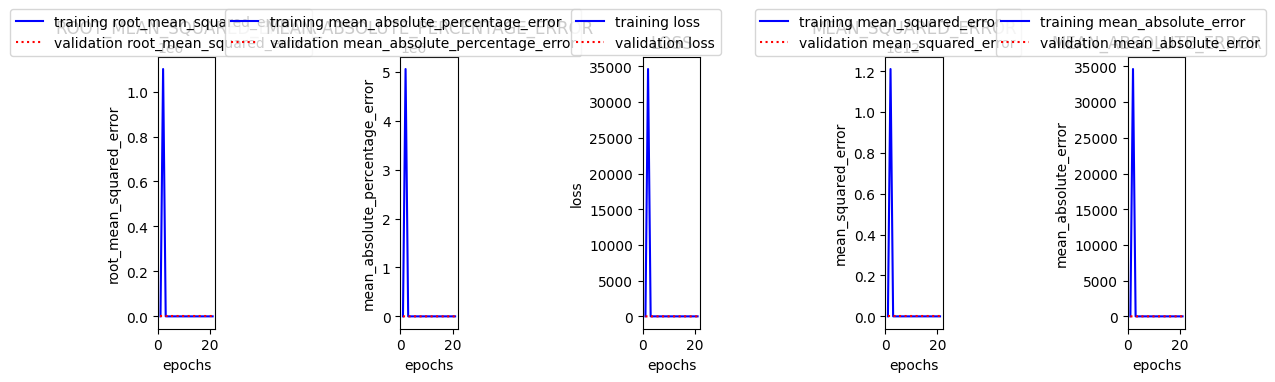

In [17]:
# Visualize Train History
def vis(history,name) :
    plt.title(f"{name.upper()}")
    plt.xlabel('epochs')
    plt.ylabel(f"{name.lower()}")
    value = history.history.get(name)
    val_value = history.history.get(f"val_{name}",None)
    epochs = range(1, len(value)+1)
    plt.plot(epochs, value, 'b-', label=f'training {name}')
    if val_value is not None :
        plt.plot(epochs, val_value, 'r:', label=f'validation {name}')
    plt.legend(loc='upper center', bbox_to_anchor=(0.05, 1.2) , fontsize=10 , ncol=1)

def plot_history(history) :
    key_value = list(set([i.split("val_")[-1] for i in list(history.history.keys())]))
    plt.figure(figsize=(12, 4))
    for idx , key in enumerate(key_value) :
        plt.subplot(1, len(key_value), idx+1)
        vis(history, key)
    plt.tight_layout()
    plt.show()

plot_history(history)

# Model Predict & Evaluation

In [19]:
y_pred = model.predict([test_cis2, test_radius])
print(f"Predict Result\n{y_pred[:5]}\n")
print(f"Test Dataset\n{y_test[:5]}")

496/496 [==============================] - 41s 80ms/step
Predict Result
[[1.5306474  1.3029128  1.1774224  0.85908365 0.51758146 0.44752854
  0.41831705 0.37967226 0.33975324]
 [1.5306474  1.3029128  1.1774224  0.85908365 0.51758146 0.44752854
  0.41831705 0.37967226 0.33975324]
 [1.5306474  1.3029128  1.1774224  0.85908365 0.51758146 0.44752854
  0.41831705 0.37967226 0.33975324]
 [1.5306474  1.3029128  1.1774224  0.85908365 0.51758146 0.44752854
  0.41831705 0.37967226 0.33975324]
 [1.5306474  1.3029128  1.1774224  0.85908365 0.51758146 0.44752854
  0.41831705 0.37967226 0.33975324]]

Test Dataset
[[1.80499992 1.51999995 1.35       0.98000002 0.56999998 0.49000001
  0.45999999 0.40999999 0.38      ]
 [1.81499996 1.52666664 1.36000004 0.98000002 0.56999998 0.49000001
  0.45999999 0.41999998 0.37      ]
 [1.43999996 1.24000003 1.13999996 0.83999996 0.51999998 0.45
  0.43000002 0.39000001 0.35999999]
 [1.16999998 1.02000001 0.95       0.70999999 0.45       0.39000001
  0.37       0.3400

In [20]:
scale_list.sort(reverse=True)
def unscale_values(y_list):
    unscale_list = [x * y for x,y in zip(y_list,scale_list)]
    return unscale_list

un_y_pred = unscale_values(y_pred)
un_y_test = unscale_values(y_test)

col_list = ["1","2","5","10","50","100","150","300","1000"]
y_real_df = pd.DataFrame(columns=col_list, data=un_y_test)
y_pred_df = pd.DataFrame(columns=col_list, data=un_y_pred)

In [21]:
def pearson_correlation_coefficient(X, Y):
    """
    두 변수 X와 Y 간의 피어슨 상관계수를 계산하는 함수

    :param X: 첫 번째 변수의 값들을 담은 1차원 NumPy 배열
    :param Y: 두 번째 변수의 값들을 담은 1차원 NumPy 배열
    :return: 피어슨 상관계수
    """
    # 변수들의 평균 계산
    mean_X = np.mean(X)
    mean_Y = np.mean(Y)

    # 각 변수들의 편차 계산
    deviation_X = X - mean_X
    deviation_Y = Y - mean_Y

    # 피어슨 상관계수의 분자 계산
    numerator = np.sum(deviation_X * deviation_Y)

    # 피어슨 상관계수의 분모 계산
    denominator = np.sqrt(np.sum(deviation_X ** 2) * np.sum(deviation_Y ** 2))

    # 피어슨 상관계수 계산
    pearson_coefficient = numerator / denominator

    return pearson_coefficient

In [22]:
mae_list = []
mse_list = []
rmse_list = []
mape_list = []
r2_list = []
pc_list = []
for i in range(len(col_list)):
    #print(f"{col_list[i]}")
    real_v = list(y_real_df[col_list[i]].values)
    pred_v = list(y_pred_df[col_list[i]].values)

    mae = mean_absolute_error(real_v, pred_v)
    mse = mean_squared_error(real_v, pred_v)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(real_v, pred_v)
    r2_scores = r2_score(real_v, pred_v)
    pearson_scores = pearson_correlation_coefficient(real_v, pred_v)

    mae_list.append(mae)
    mse_list.append(mse)
    rmse_list.append(rmse)
    mape_list.append(mape)
    r2_list.append(r2_scores)
    pc_list.append(pearson_scores)

ev_df = pd.DataFrame(columns=["MAE","MSE","RMSE","MAPE","R2","Pearson"])
ev_df["MAE"] = mae_list
ev_df["MSE"] = mse_list
ev_df["RMSE"] = rmse_list
ev_df["MAPE"] = mape_list
ev_df["R2"] = r2_list
ev_df["Pearson"] = pc_list
ev_df.index = col_list

In [23]:
ev_df

,MAE,MSE,RMSE,MAPE,R2,Pearson
1,3.220325,14.043945,3.747525,0.159697,0.717784,0.926150
2,2.564148,9.037892,3.006309,0.149333,0.736557,0.930795
5,2.096394,6.252146,2.500429,0.135118,0.760252,0.935596
10,1.439952,3.016189,1.736718,0.126614,0.774479,0.940334
50,0.661731,0.720797,0.848998,0.097549,0.828835,0.950246
100,0.534453,0.441169,0.664206,0.092894,0.855646,0.959722
150,0.471450,0.323902,0.569124,0.087464,0.879750,0.971504
300,0.380873,0.218120,0.467033,0.078207,0.897626,0.974349
1000,0.362893,0.181973,0.426583,0.083262,0.905671,0.979969


# Export Model

In [24]:
!pip install tf2onnx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 451.2/451.2 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 62.0 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 23.5.26
    Uninstalling flatbuffers-23.5.26:
      Successfully uninstalled flatbuffers-23.5.26


In [ ]:
import tf2onnx

# 변환할 모델을 입력합니다.
input_signature = [
    tf.TensorSpec(shape=(None, train_cis1.shape[1],train_cis1.shape[2],train_cis1.shape[3],train_cis1.shape[4]), dtype=tf.float32),
    tf.TensorSpec(shape=(None, train_cis2.shape[1],train_cis2.shape[2],train_cis2.shape[3],train_cis2.shape[4]), dtype=tf.float32),
    tf.TensorSpec(shape=(None, train_radius.shape[1]), dtype=tf.float32)
]
# tf2onnx 변환 함수를 사용하여 모델을 ONNX로 변환합니다.
onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=input_signature)

# ONNX 모델을 파일로 저장합니다.
with open(f"./Method3_CNN_{r_mode}_{c_mode}_{m_mode}.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())